In [6]:
import numpy as np
from collections import Counter

y = np.load("../data/landmarks_norm/y.npy")
print("Total samples:", len(y))

# Count all labels
counts = Counter(y)
for label_idx in sorted(counts):
    print(f"Label {label_idx}: {counts[label_idx]}")

print("Classes:", classes)


Total samples: 373
Label Alright: 19
Label Bad: 20
Label Beautiful: 13
Label Blind: 20
Label Deaf: 15
Label Good: 20
Label Good_afternoon: 20
Label Good_morning: 20
Label He: 20
Label Hello: 20
Label How_are_you: 20
Label I: 20
Label IT: 20
Label Loud: 20
Label Quiet: 20
Label Sad: 13
Label She: 20
Label Ugly: 13
Label You: 20
Label happy: 20
Classes: ['Alright' 'Bad' 'Beautiful' 'Blind' 'Deaf' 'Good' 'Good_afternoon'
 'Good_morning' 'He' 'Hello' 'How_are_you' 'I' 'IT' 'Loud' 'Quiet' 'Sad'
 'She' 'Ugly' 'You' 'happy']


In [7]:
# This code is safe to run in your notebook
from collections import Counter

val_labels = []
for batch in val_loader:
    labels = batch[-1]
    val_labels.extend(labels.numpy().tolist())

print("\nVal label counts:")
print(Counter(val_labels))
print("Unique labels in val set:", sorted(set(val_labels)))
print("Expected total classes:", len(classes))



Val label counts:
Counter({6: 7, 8: 7, 18: 6, 12: 5, 9: 5, 1: 5, 14: 5, 7: 5, 3: 3, 0: 3, 5: 3, 4: 3, 19: 3, 13: 3, 2: 3, 15: 2, 16: 2, 10: 2, 17: 2})
Unique labels in val set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
Expected total classes: 20


Classes: ['Alright' 'Bad' 'Beautiful' 'Blind' 'Deaf' 'Good' 'Good_afternoon'
 'Good_morning' 'He' 'Hello' 'How_are_you' 'I' 'IT' 'Loud' 'Quiet' 'Sad'
 'She' 'Ugly' 'You' 'happy']
Loaded best model checkpoint!
Confusion matrix shape: (20, 20), Expected: (20,20)


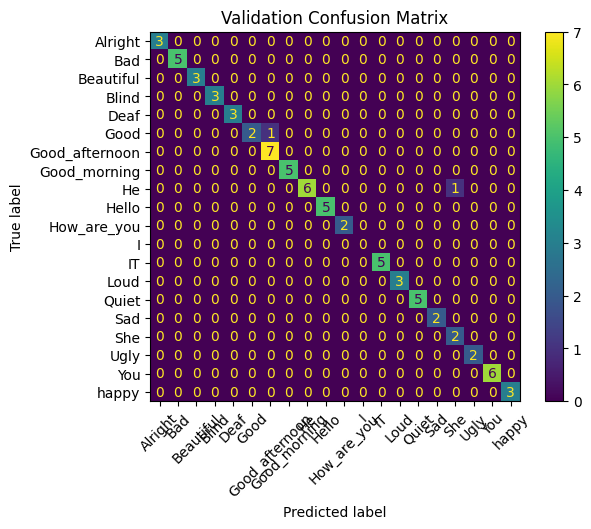


Classification Report:


ValueError: Number of classes, 19, does not match size of target_names, 20. Try specifying the labels parameter

In [9]:
# notebooks/test_inference.ipynb


import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.multiclass import unique_labels
import sys, os
sys.path.append(os.path.abspath(".."))

from models.sign_model import SignLanguageModel
from src.landmarks.dataset import make_dataloaders

# -------------------------------
# Load Data
# -------------------------------
train_loader, val_loader, num_classes, classes = make_dataloaders(
    data_dir="../data/landmarks_norm",
    batch_size=1,  # for single sample inference
    val_split=0.2
)

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available() else "cpu")

print("Classes:", classes)

# -------------------------------
# Load Best Model
# -------------------------------
best_cnn_out = 96
best_lstm_hidden = 64

model = SignLanguageModel(
    cnn_out=best_cnn_out,
    lstm_hidden=best_lstm_hidden,
    num_classes=num_classes,
    bidirectional=True
).to(device)

# Rebuild same classifier head
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(best_lstm_hidden * 2 * 4, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, num_classes)
).to(device)

model.load_state_dict(torch.load("../models/best_sign_model_hp_tuned.pth"))
model.eval()

print("Loaded best model checkpoint!")

# -------------------------------
# Inference on Val Set
# -------------------------------
y_true = []
y_pred = []

with torch.no_grad():
    for batch in val_loader:
        pose, face, lhand, rhand, pose_mask, face_mask, lhand_mask, rhand_mask, labels = [b.to(device) for b in batch]

        logits = model(pose, face, lhand, rhand, pose_mask, face_mask, lhand_mask, rhand_mask)
        preds = torch.argmax(logits, dim=1)

        y_true.append(labels.item())
        y_pred.append(preds.item())

# -------------------------------
# Confusion Matrix
# -------------------------------
all_class_indices = list(range(num_classes))  # [0, 1, ..., 19]

cm = confusion_matrix(y_true, y_pred, labels=all_class_indices)

print(f"Confusion matrix shape: {cm.shape}, Expected: ({num_classes},{num_classes})")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.show()

# -------------------------------
# Classification Report
# -------------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

print("Unique y_true:", sorted(set(y_true)))
print("Unique y_pred:", sorted(set(y_pred)))
print("Expected class count:", len(classes))

for idx, cls in enumerate(classes):
    print(idx, cls)
print("Total classes:", len(classes))

